# Modelo de predição de preço de laptops

Os dados foram obtidos no dataset de Anubhal Goyal, disponibilizando no Kaggle por meio deste [link](https://www.kaggle.com/datasets/anubhavgoyal10/laptop-prices-dataset).
O arquivo original já foi baixado na pasta ```data/raw```

In [41]:
import pandas as pd
import numpy as np

from sklearn.svm import SVR as supportVectorRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

%matplotlib inline

import matplotlib.pyplot as plt


In [2]:
np.__version__

'1.25.2'

In [3]:
df = pd.read_csv("../data/raw/laptopPrice.csv")
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


## Pré-processamento

Padronização dos dados, consistindo nas etapas de:

* Padronização de caixa baixa
* Transformação de valores _string_ para _long_
* Transformação e criação de novos features

In [4]:
df_transformed = df.copy()

df_transformed = df_transformed.astype(str).apply(lambda x: x.str.lower())

In [5]:
df_transformed.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,asus,intel,core i3,10th,4 gb,ddr4,0 gb,1024 gb,windows,64-bit,0 gb,casual,no warranty,no,no,34649,2 stars,3,0
1,lenovo,intel,core i3,10th,4 gb,ddr4,0 gb,1024 gb,windows,64-bit,0 gb,casual,no warranty,no,no,38999,3 stars,65,5
2,lenovo,intel,core i3,10th,4 gb,ddr4,0 gb,1024 gb,windows,64-bit,0 gb,casual,no warranty,no,no,39999,3 stars,8,1
3,asus,intel,core i5,10th,8 gb,ddr4,512 gb,0 gb,windows,32-bit,2 gb,casual,no warranty,no,no,69990,3 stars,0,0
4,asus,intel,celeron dual,not available,4 gb,ddr4,0 gb,512 gb,windows,64-bit,0 gb,casual,no warranty,no,no,26990,3 stars,0,0


As colunas a seguir não deverão ser utilizadas pois elas não conseguem ser simuladas por um serviço projetado da qual o usuário irá fornecer as características para a simulação do preço do laptop.

In [6]:
df_transformed.drop("rating", axis=1, inplace=True)
df_transformed.drop("Number of Ratings", axis=1, inplace=True)
df_transformed.drop("Number of Reviews", axis=1, inplace=True)
df_transformed.drop("msoffice", axis=1, inplace=True)
df_transformed.drop("processor_gnrtn", axis=1, inplace=True)

Ajustando os dados para remover e adaptar conteúdos _string_ para _numeric_.

In [7]:
df_transformed['ram_gb'] = df_transformed['ram_gb'].replace({' gb' : ''}, regex=True)
df_transformed['ssd'] = df_transformed['ssd'].replace({' gb' : ''}, regex=True)
df_transformed['hdd'] = df_transformed['hdd'].replace({' gb' : ''}, regex=True)
df_transformed['graphic_card_gb'] = df_transformed['ram_gb'].replace({' gb' : ''}, regex=True)
df_transformed['warranty'] = df_transformed['warranty'].replace({'no warranty' : '0'}, regex=True)
df_transformed['warranty'] = df_transformed['warranty'].replace({' (years|year)' : ''}, regex=True)
df_transformed['Touchscreen'] = df_transformed['Touchscreen'].replace({'no' : '0'}, regex=True)
df_transformed['Touchscreen'] = df_transformed['Touchscreen'].replace({'yes' : '1'}, regex=True)

In [8]:
df_transformed = df_transformed.rename(columns={"Touchscreen": "touchscreen","Price": "price"})

In [9]:
df_transformed.head()

,brand,processor_brand,processor_name,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,touchscreen,price
0,asus,intel,core i3,4,ddr4,0,1024,windows,64-bit,4,casual,0,0,34649
1,lenovo,intel,core i3,4,ddr4,0,1024,windows,64-bit,4,casual,0,0,38999
2,lenovo,intel,core i3,4,ddr4,0,1024,windows,64-bit,4,casual,0,0,39999
3,asus,intel,core i5,8,ddr4,512,0,windows,32-bit,8,casual,0,0,69990
4,asus,intel,celeron dual,4,ddr4,0,512,windows,64-bit,4,casual,0,0,26990


Convertendo os tipos de dados para cada coluna, convertendo os tipos adequados, ou seja, valores numéricos deverão ser convertidos para inteiro.

In [10]:
df_transformed['ram_gb'] = pd.to_numeric(df_transformed['ram_gb'], errors='coerce').fillna(0).astype(np.int64)
df_transformed['hdd'] = pd.to_numeric(df_transformed['hdd'], errors='coerce').fillna(0).astype(np.int64)
df_transformed['ssd'] = pd.to_numeric(df_transformed['ssd'], errors='coerce').fillna(0).astype(np.int64)
df_transformed['graphic_card_gb'] = pd.to_numeric(df_transformed['graphic_card_gb'], errors='coerce').fillna(0).astype(np.int64)
df_transformed['warranty'] = pd.to_numeric(df_transformed['warranty'], errors='coerce').fillna(0).astype(np.int64)
df_transformed['price'] = pd.to_numeric(df_transformed['price'], errors='coerce').fillna(0).astype(np.float64)
df_transformed['touchscreen'] = pd.to_numeric(df_transformed['touchscreen'], errors='coerce').fillna(0).astype(np.int64)
df_transformed['price'] = pd.to_numeric(df_transformed['price'], errors='coerce').fillna(0).astype(np.int64)

Diminuir a quantidade de itens para tornar o modelo mais simples e balancear os dados.

In [11]:
df_transformed["processor_name"].unique()

array(['core i3', 'core i5', 'celeron dual', 'ryzen 5', 'core i7',
       'core i9', 'm1', 'pentium quad', 'ryzen 3', 'ryzen 7', 'ryzen 9'],
      dtype=object)

In [12]:
df_transformed["os"].unique()

array(['windows', 'dos', 'mac'], dtype=object)

In [13]:
df_transformed["processor_name"].unique()

array(['core i3', 'core i5', 'celeron dual', 'ryzen 5', 'core i7',
       'core i9', 'm1', 'pentium quad', 'ryzen 3', 'ryzen 7', 'ryzen 9'],
      dtype=object)

In [14]:
df_transformed["ram_type"].unique()

array(['ddr4', 'lpddr4', 'lpddr4x', 'ddr5', 'ddr3', 'lpddr3'],
      dtype=object)

In [15]:
df_transformed["weight"].unique()

array(['casual', 'thinnlight', 'gaming'], dtype=object)

In [16]:
replace_dict = {'mac': 'other', 'dos': 'other'}
df_transformed['os'].replace(replace_dict, inplace=True)

replace_dict = {'lpddr4x': 'other', 'lpddr4': 'other', 'lpddr3': 'other','ddr5':'other','ddr3':'other'}
df_transformed['ram_type'].replace(replace_dict, inplace=True)

replace_dict = {'core i9': 'other', 'pentium quad': 'other', 'm1': 'other','celeron dual':'other','ryzen 9':'other','ryzen 3':'ryzen 7'}
df_transformed['processor_name'].replace(replace_dict, inplace=True)

replace_dict = {'acer': 'other', 'msi': 'other', 'apple': 'other','avita':'other'}
df_transformed['brand'].replace(replace_dict, inplace=True)

Remover itens duplicados.

In [17]:
df_transformed.drop_duplicates(inplace=True)

In [18]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 779 entries, 0 to 822
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand            779 non-null    object
 1   processor_brand  779 non-null    object
 2   processor_name   779 non-null    object
 3   ram_gb           779 non-null    int64 
 4   ram_type         779 non-null    object
 5   ssd              779 non-null    int64 
 6   hdd              779 non-null    int64 
 7   os               779 non-null    object
 8   os_bit           779 non-null    object
 9   graphic_card_gb  779 non-null    int64 
 10  weight           779 non-null    object
 11  warranty         779 non-null    int64 
 12  touchscreen      779 non-null    int64 
 13  price            779 non-null    int64 
dtypes: int64(7), object(7)
memory usage: 91.3+ KB


In [19]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df_transformed, title="Profiling Report")

profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
df_transformed

,brand,processor_brand,processor_name,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,touchscreen,price
0,asus,intel,core i3,4,ddr4,0,1024,windows,64-bit,4,casual,0,0,34649
1,lenovo,intel,core i3,4,ddr4,0,1024,windows,64-bit,4,casual,0,0,38999
2,lenovo,intel,core i3,4,ddr4,0,1024,windows,64-bit,4,casual,0,0,39999
3,asus,intel,core i5,8,ddr4,512,0,windows,32-bit,8,casual,0,0,69990
4,asus,intel,other,4,ddr4,0,512,windows,64-bit,4,casual,0,0,26990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,asus,amd,other,4,ddr4,1024,0,windows,64-bit,4,casual,1,0,135990
819,asus,amd,other,4,ddr4,1024,0,windows,64-bit,4,casual,1,0,144990
820,asus,amd,other,4,ddr4,1024,0,windows,64-bit,4,casual,1,0,149990
821,asus,amd,other,4,ddr4,1024,0,windows,64-bit,4,casual,1,0,142990


Criando atributos one hot enconded.

In [21]:
df_transformed = pd.get_dummies(df_transformed, columns=["brand"], prefix="brand")
df_transformed = pd.get_dummies(df_transformed, columns=["processor_brand"], prefix="processor_brand")
df_transformed = pd.get_dummies(df_transformed, columns=["processor_name"], prefix="processor_name")

df_transformed = pd.get_dummies(df_transformed, columns=["os"], prefix="os")
df_transformed = pd.get_dummies(df_transformed, columns=["weight"], prefix="weight")
df_transformed = pd.get_dummies(df_transformed, columns=["warranty"], prefix="warranty")
df_transformed = pd.get_dummies(df_transformed, columns=["touchscreen"], prefix="touchscreen")
df_transformed = pd.get_dummies(df_transformed, columns=["ram_gb"], prefix="ram_gb")

df_transformed = pd.get_dummies(df_transformed, columns=["hdd"], prefix="hdd")
df_transformed = pd.get_dummies(df_transformed, columns=["ssd"], prefix="ssd")

df_transformed = pd.get_dummies(df_transformed, columns=["graphic_card_gb"], prefix="graphic_card_gb")
df_transformed = pd.get_dummies(df_transformed, columns=["ram_type"], prefix="ram_type")

df_transformed = pd.get_dummies(df_transformed, columns=["os_bit"], prefix="os_bit")

Criando atributos categóricos baseados em números.

In [22]:
df_transformed

,price,brand_asus,brand_dell,brand_hp,brand_lenovo,brand_other,processor_brand_amd,processor_brand_intel,processor_brand_m1,processor_name_core i3,...,ssd_2048,ssd_3072,graphic_card_gb_4,graphic_card_gb_8,graphic_card_gb_16,graphic_card_gb_32,ram_type_ddr4,ram_type_other,os_bit_32-bit,os_bit_64-bit
0,34649,True,False,False,False,False,False,True,False,True,...,False,False,True,False,False,False,True,False,False,True
1,38999,False,False,False,True,False,False,True,False,True,...,False,False,True,False,False,False,True,False,False,True
2,39999,False,False,False,True,False,False,True,False,True,...,False,False,True,False,False,False,True,False,False,True
3,69990,True,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,True,False,True,False
4,26990,True,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,135990,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True
819,144990,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True
820,149990,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True
821,142990,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True


## Treinamento

Dado o objetivo de estimar o valor do notebook com base nos atributos fornecidos, vamos resolver com algoritmos de regressão.

In [23]:
features = list(df_transformed.columns)

features.remove("price")

features

['brand_asus',
 'brand_dell',
 'brand_hp',
 'brand_lenovo',
 'brand_other',
 'processor_brand_amd',
 'processor_brand_intel',
 'processor_brand_m1',
 'processor_name_core i3',
 'processor_name_core i5',
 'processor_name_core i7',
 'processor_name_other',
 'processor_name_ryzen 5',
 'processor_name_ryzen 7',
 'os_other',
 'os_windows',
 'weight_casual',
 'weight_gaming',
 'weight_thinnlight',
 'warranty_0',
 'warranty_1',
 'warranty_2',
 'warranty_3',
 'touchscreen_0',
 'touchscreen_1',
 'ram_gb_4',
 'ram_gb_8',
 'ram_gb_16',
 'ram_gb_32',
 'hdd_0',
 'hdd_512',
 'hdd_1024',
 'hdd_2048',
 'ssd_0',
 'ssd_128',
 'ssd_256',
 'ssd_512',
 'ssd_1024',
 'ssd_2048',
 'ssd_3072',
 'graphic_card_gb_4',
 'graphic_card_gb_8',
 'graphic_card_gb_16',
 'graphic_card_gb_32',
 'ram_type_ddr4',
 'ram_type_other',
 'os_bit_32-bit',
 'os_bit_64-bit']

In [24]:
X = df_transformed[features]

X

,brand_asus,brand_dell,brand_hp,brand_lenovo,brand_other,processor_brand_amd,processor_brand_intel,processor_brand_m1,processor_name_core i3,processor_name_core i5,...,ssd_2048,ssd_3072,graphic_card_gb_4,graphic_card_gb_8,graphic_card_gb_16,graphic_card_gb_32,ram_type_ddr4,ram_type_other,os_bit_32-bit,os_bit_64-bit
0,True,False,False,False,False,False,True,False,True,False,...,False,False,True,False,False,False,True,False,False,True
1,False,False,False,True,False,False,True,False,True,False,...,False,False,True,False,False,False,True,False,False,True
2,False,False,False,True,False,False,True,False,True,False,...,False,False,True,False,False,False,True,False,False,True
3,True,False,False,False,False,False,True,False,False,True,...,False,False,False,True,False,False,True,False,True,False
4,True,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,True,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
819,True,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
820,True,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
821,True,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True


In [25]:
y = df_transformed["price"]
y

0       34649
1       38999
2       39999
3       69990
4       26990
        ...  
818    135990
819    144990
820    149990
821    142990
822     57490
Name: price, Length: 779, dtype: int64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Primeiro teste básico com regressão linear

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2: {r2}')

Mean Squared Error: 664421467.2991453
Mean Absolute Error: 16431.53846153846
R2: 0.6473758117933883


Segundo teste com regressor SVM

In [28]:
model = supportVectorRegressor() 
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2: {r2}')

Mean Squared Error: 2042729456.1800225
Mean Absolute Error: 29892.9872618399
R2: -0.08412483892080957


In [29]:
X_test.columns

Index(['brand_asus', 'brand_dell', 'brand_hp', 'brand_lenovo', 'brand_other',
       'processor_brand_amd', 'processor_brand_intel', 'processor_brand_m1',
       'processor_name_core i3', 'processor_name_core i5',
       'processor_name_core i7', 'processor_name_other',
       'processor_name_ryzen 5', 'processor_name_ryzen 7', 'os_other',
       'os_windows', 'weight_casual', 'weight_gaming', 'weight_thinnlight',
       'warranty_0', 'warranty_1', 'warranty_2', 'warranty_3', 'touchscreen_0',
       'touchscreen_1', 'ram_gb_4', 'ram_gb_8', 'ram_gb_16', 'ram_gb_32',
       'hdd_0', 'hdd_512', 'hdd_1024', 'hdd_2048', 'ssd_0', 'ssd_128',
       'ssd_256', 'ssd_512', 'ssd_1024', 'ssd_2048', 'ssd_3072',
       'graphic_card_gb_4', 'graphic_card_gb_8', 'graphic_card_gb_16',
       'graphic_card_gb_32', 'ram_type_ddr4', 'ram_type_other',
       'os_bit_32-bit', 'os_bit_64-bit'],
      dtype='object')

In [30]:
#brand_asus
#brand_dell
#brand_hp
#brand_lenovo
#brand_other
#processor_brand_amd
#processor_brand_intel
#processor_brand_m1
#processor_name_core i3
#processor_name_core i5
#processor_name_core i7
#processor_name_other
#processor_name_ryzen 5
#processor_name_ryzen 7
#os_other
#os_windows
#weight_casual
#weight_gaming
#weight_thinnlight
#warranty_0
#warranty_1
#warranty_2
#warranty_3
#touchscreen_0
#touchscreen_1
#ram_gb_4
#ram_gb_8
#ram_gb_16
#ram_gb_32
#hdd_0
#hdd_512
#hdd_1024
#hdd_2048
#ssd_0
#ssd_128
#ssd_256
#ssd_512
#ssd_1024
#ssd_2048
#ssd_3072
#graphic_card_gb_4
#graphic_card_gb_8
#graphic_card_gb_16
#graphic_card_gb_32
#ram_type_ddr4
#ram_type_other
#os_bit_32-bit
#os_bit_64-bit'

In [31]:
dados_inferencia = []
#brand_asus
dados_inferencia.append(0)
#brand_dell
dados_inferencia.append(1)
#brand_hp
dados_inferencia.append(0)
#brand_lenovo
dados_inferencia.append(0)
#brand_other
dados_inferencia.append(0)
#processor_brand_amd
dados_inferencia.append(0)
#processor_brand_intel
dados_inferencia.append(1)
#processor_brand_m1
dados_inferencia.append(0)
#processor_name_core i3
dados_inferencia.append(0)
#processor_name_core i5
dados_inferencia.append(1)
#processor_name_core i7
dados_inferencia.append(0)
#processor_name_other
dados_inferencia.append(0)
#processor_name_ryzen 5
dados_inferencia.append(0)
#processor_name_ryzen 7
dados_inferencia.append(0)
#os_other
dados_inferencia.append(0)
#os_windows
dados_inferencia.append(1)
#weight_casual
dados_inferencia.append(1)
#weight_gaming
dados_inferencia.append(0)
#weight_thinnlight
dados_inferencia.append(0)
#warranty_0
dados_inferencia.append(0)
#warranty_1
dados_inferencia.append(1)
#warranty_2
dados_inferencia.append(0)
#warranty_3
dados_inferencia.append(0)
#touchscreen_0
dados_inferencia.append(1)
#touchscreen_1
dados_inferencia.append(0)
#ram_gb_4
dados_inferencia.append(0)
#ram_gb_8
dados_inferencia.append(0)
#ram_gb_16
dados_inferencia.append(1)
#ram_gb_32
dados_inferencia.append(0)
#hdd_0
dados_inferencia.append(0)
#hdd_512
dados_inferencia.append(0)
#hdd_1024
dados_inferencia.append(0)
#hdd_2048
dados_inferencia.append(0)
#ssd_0
dados_inferencia.append(0)
#ssd_128
dados_inferencia.append(0)
#ssd_256
dados_inferencia.append(1)
#ssd_512
dados_inferencia.append(0)
#ssd_1024
dados_inferencia.append(0)
#ssd_2048
dados_inferencia.append(0)
#ssd_3072
dados_inferencia.append(0)
#graphic_card_gb_4
dados_inferencia.append(0)
#graphic_card_gb_8
dados_inferencia.append(1)
#graphic_card_gb_16
dados_inferencia.append(0)
#graphic_card_gb_32
dados_inferencia.append(0)
#ram_type_ddr4
dados_inferencia.append(1)
#ram_type_other
dados_inferencia.append(0)
#os_bit_32-bit
dados_inferencia.append(0)
#os_bit_64-bit
dados_inferencia.append(1)

In [32]:
model.predict([dados_inferencia])

d:\GitHub_Projects\fiap-ds-mlops-laptop-pricing\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


array([64187.25070834])

In [37]:
%matplotlib widget

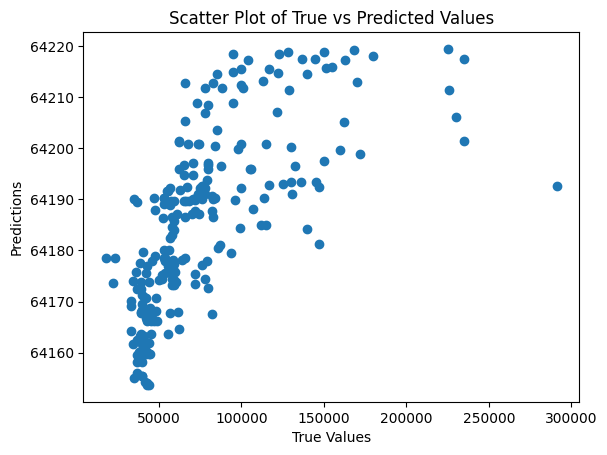

In [43]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter Plot of True vs Predicted Values')
#plt.savefig("by_region.png",dpi=80)
plt.show()